In [1]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.utils import class_weight

import statistics 

import matplotlib.pyplot as plt

import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation
import os 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM
from tensorflow.keras.models import Model

from scipy.signal import savgol_filter

import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import Callback

import random
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

import pathlib
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2021-12-03 11:41:21.249016: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2021-12-03 11:41:22.060319: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2021-12-03 11:41:22.103172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-12-03 11:41:22.103220: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2021-12-03 11:41:22.106905: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-12-03 11:41:22.106967: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2021-12-03 11:41:22.108552: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
def plot_confusion_matrix_norm(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")

    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.savefig("out/"+dataset+str(seed),dpi=300)

In [3]:
def LSTM_3D_V56(X_train, num_classes, lr = 0.0001):
    
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #out = Dropout(0.10)(out)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False, dropout=0.1)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.1)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [ ]:
def CNN_V56(X_train, num_classes, lr = 0.0001):


    input_a = Input(shape = X_train.shape[1: ])

    x = (Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    x = (Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = (Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = (Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = (Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = (Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    x = (Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = (Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    out = (Flatten())(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [ ]:
def LSTM_BI_V56(X_train, num_classes, lr = 0.0001):


    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #out = Dropout(0.10)(out)
    x = TimeDistributed(Flatten())(x)
    x = layers.Bidirectional(LSTM(32, return_sequences=True, unroll=False, dropout=0.1))(x)  # dropout=0.6
    out = layers.Bidirectional(LSTM(32, return_sequences=False, unroll=False, dropout=0.1))(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    

    return model

In [4]:
x_train = 0
x_test = 0
y_train = 0
y_test = 0
d_class_weights = 0

In [5]:
#train test split
#print("...spliting")
def split_to_train_test(seed):
    

    #print("loading labels")
    Y = file["labels/gaf"][:]
    #print("loading images")
    X =  file["data/gaf"]
    x_ids = list(range(len(X)))
    
    x_train, x_test, y_train, y_test = train_test_split(np.array(file["data/gaf"]),Y,test_size=0.2,random_state=seed,stratify=Y)
    
    print("split shapes shapes:")
    print("train samples",len(y_train))
    print("test samples",len(y_test))
    print("counts")
    for ctest,ctrain,appl in zip(np.unique(y_test,return_counts=True)[1],np.unique(y_train,return_counts=True)[1],appliances):
        print(appl,"test:",ctest,"train:",ctrain)
    #convert
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_of_classes)
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_of_classes)


    class_weights = class_weight.compute_class_weight(class_weight="balanced", classes = np.unique(Y), y=Y)
    d_class_weights = dict(enumerate(class_weights))
    print(d_class_weights)
    
    return x_train, x_test, y_train,y_test,d_class_weights

In [6]:
def create_tl_model(model):
    print("compling TL model..")
    #create TL model 
    path_model = path+"/models/LAST/"+model
    #path_model = path+"/models/refit/GSAF/LSTM3DV56/model2"

    model = keras.models.load_model(path_model)
    #create trasfer learning model 
    model.trainable = False
    base_output = model.layers[-2].output
    hidden4 = Dense(64, activation='relu')(base_output)
    hidden3 = Dense(32, activation='relu')(hidden4)
    hidden2 = Dense(16, activation='relu')(hidden3)
    hidden = Dense(num_of_classes, activation='softmax')(hidden2)

    model2 = keras.models.Model(model.inputs, hidden)
    lr = 0.002
    adam = optimizers.Adam(lr = lr)
    model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model2

In [7]:
def print_eval_results():
    #eval 
    #Print results and plot confusion matrix

    #print('Test accuracy: ', results[1])
    #print("Loss: "f"{results[0]}")
    Y_pred = model_used.predict(x_test, verbose = 2)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_test = np.argmax(y_test, axis=-1)
    C = confusion_matrix(Y_test, y_pred)
    # B =np.around((C / C.astype(np.float).sum(axis=1))*100,2)
    print(confusion_matrix(Y_test, y_pred))
    precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
    print("F1 SCORE",fscore)
    plot_confusion_matrix_norm(C, appliances, normalize=True)
    print(classification_report(Y_test, y_pred, target_names=appliances))

In [8]:
#LOAD DATASET
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "iawe_gen_GASF_13m_100S5X4A1545"
#read the file
#file_name="redd_gen_GASF_13m_100S5X5A4934"
file_name="eco_gen_GASF_13m_100S5X11A38085"
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [9]:
#fetch array of appliances
enc_appliances = np.array(file["appliances/classes"])
appliances = [n.decode("utf-8") for n in enc_appliances]
num_of_classes = file["appliances/classes"].shape[0]

print(appliances)

#data_train = np.array(file['data/train']['gasf'])
#X = np.array(file['data/test']['gaf'])
#y_test = np.array(file['labels/test']['gasf'])
#Y = np.array(file['labels/test']['gaf'])
#y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_of_classes)
# X_train = np.array(file['data/train']['gaf'])

['HEKA', 'fridge/freezer', 'HTPC', 'audio system', 'broadband router', 'coffee maker', 'computer', 'lamp', 'laptop computer', 'microwave', 'washing machine']


In [10]:
seed = 82
x_train, x_test, y_train,y_test, d_class_weights = split_to_train_test(seed)

split shapes shapes:
train samples 30468
test samples 7617
counts
HEKA test: 146 train: 586
fridge/freezer test: 3893 train: 15571
HTPC test: 1173 train: 4691
audio system test: 276 train: 1104
broadband router test: 314 train: 1257
coffee maker test: 65 train: 261
computer test: 839 train: 3358
lamp test: 216 train: 862
laptop computer test: 514 train: 2055
microwave test: 134 train: 534
washing machine test: 47 train: 189
{0: 4.7298807749627425, 1: 0.1778808429548257, 2: 0.5904285005581049, 3: 2.508893280632411, 4: 2.2038655170418378, 5: 10.620468488566647, 6: 0.8249398921307427, 7: 3.2117557766908416, 8: 1.3477122332708165, 9: 5.183043004899292, 10: 14.67064714946071}


In [11]:
#model = LSTM_3D_V56(x_train,num_of_classes,lr = 0.00002) #0
model = CNN_V56(x_train,num_of_classes,lr = 0.00002) #0

2021-12-03 11:41:36.456814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-12-03 11:41:36.457429: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2021-12-03 11:41:36.457510: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2021-12-03 11:41:36.768340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-12-03 11:41:36.768376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2021-12-03 11:41:36.768386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2021-12-03 11:41:36.768951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

In [12]:
model_used = model
dataset = "eco"
model_used.fit(x_train, y_train, batch_size = 64, epochs = 150, verbose = 1,class_weight=d_class_weights)

results = model_used.evaluate(x_test, y_test, verbose = 2)
print('Test accuracy: ', results[1])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/150


2021-12-03 11:41:40.110273: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-03 11:41:40.128428: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz
2021-12-03 11:41:42.168130: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2021-12-03 11:41:42.616161: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2021-12-03 11:41:43.111547: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-12-03 11:41:43.520003: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


477/477 [==============================] - 55s 106ms/step - loss: 2.2846 - accuracy: 0.0699
Epoch 2/150
477/477 [==============================] - 50s 105ms/step - loss: 2.0991 - accuracy: 0.1386
Epoch 3/150
477/477 [==============================] - 50s 105ms/step - loss: 1.9554 - accuracy: 0.2980
Epoch 4/150
477/477 [==============================] - 50s 105ms/step - loss: 1.7865 - accuracy: 0.4280
Epoch 5/150
477/477 [==============================] - 50s 105ms/step - loss: 1.5916 - accuracy: 0.5230
Epoch 6/150
477/477 [==============================] - 50s 105ms/step - loss: 1.4095 - accuracy: 0.5790
Epoch 7/150
477/477 [==============================] - 50s 105ms/step - loss: 1.3081 - accuracy: 0.5426
Epoch 8/150
477/477 [==============================] - 50s 105ms/step - loss: 1.1589 - accuracy: 0.6270
Epoch 9/150
477/477 [==============================] - 50s 105ms/step - loss: 1.0600 - accuracy: 0.6475
Epoch 10/150
477/477 [==============================] - 50s 105ms/step - los

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



477/477 [==============================] - 50s 105ms/step - loss: 0.2062 - accuracy: 0.8996
Epoch 127/150
477/477 [==============================] - 50s 105ms/step - loss: 0.1981 - accuracy: 0.9076
Epoch 128/150
477/477 [==============================] - 50s 105ms/step - loss: 0.1952 - accuracy: 0.9077
Epoch 129/150
477/477 [==============================] - 50s 105ms/step - loss: 0.1954 - accuracy: 0.9079
Epoch 130/150
477/477 [==============================] - 50s 105ms/step - loss: 0.2105 - accuracy: 0.8999
Epoch 131/150
477/477 [==============================] - 50s 105ms/step - loss: 0.2088 - accuracy: 0.9013
Epoch 132/150
477/477 [==============================] - 50s 105ms/step - loss: 0.1923 - accuracy: 0.9092
Epoch 133/150
477/477 [==============================] - 50s 105ms/step - loss: 0.1847 - accuracy: 0.9128
Epoch 134/150
477/477 [==============================] - 50s 105ms/step - loss: 0.1910 - accuracy: 0.9103
Epoch 135/150
477/477 [==============================] - 50s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
#save the model
path_model= path+"/models/LAST/"+file_name.split("_")[0]
#model_used.save(path_model)

2021-11-29 21:25:25.278998: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /workspace/notebooks/models/LAST/eco/assets


INFO:tensorflow:Assets written to: /workspace/notebooks/models/LAST/eco/assets


239/239 - 3s
[[ 144    0    2    0    0    0    0    0    0    0    0]
 [   2 3700   35   57    0    0    0   91    6    0    2]
 [   0   12  775  121   24    4   22   60  155    0    0]
 [   0   11   23  237    0    1    1    3    0    0    0]
 [   0    0    3    0  311    0    0    0    0    0    0]
 [   0    0    0    0    0   65    0    0    0    0    0]
 [   0    1   19    2    0    1  759   15   42    0    0]
 [   0    9   11    5    0    0    4  186    1    0    0]
 [   0    2   12    3    1    0    2    1  493    0    0]
 [   0    0    1    0    0    0    0    0    0  133    0]
 [   0    0    0    0    0    0    0    0    0    0   47]]
F1 SCORE 0.8793635091296697
Normalized confusion matrix
                  precision    recall  f1-score   support

            HEKA       0.99      0.99      0.99       146
  fridge/freezer       0.99      0.95      0.97      3893
            HTPC       0.88      0.66      0.75      1173
    audio system       0.56      0.86      0.68       276
b

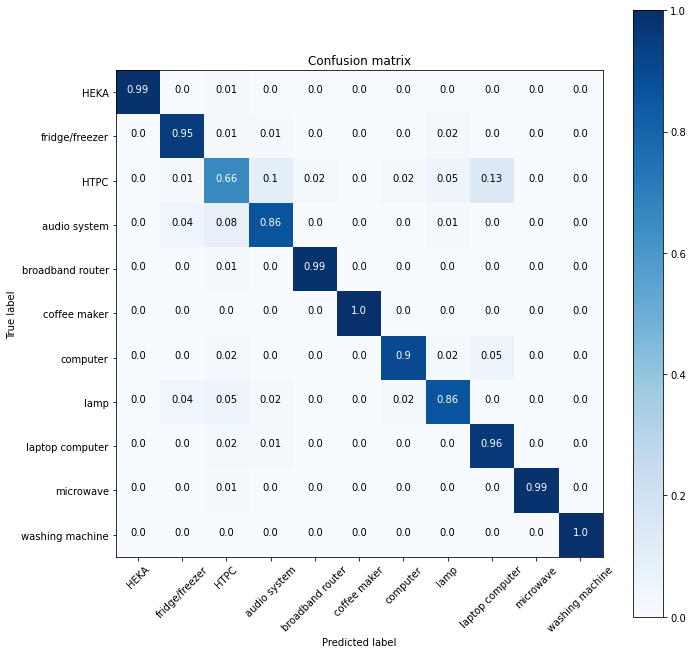

In [14]:
print_eval_results()

In [171]:
F1_d["refit"] 

[1, 2, 3]

using backcbone from base with seed 42
split shapes shapes:
train samples 3947
test samples 987
counts
fridge/freezer test: 146 train: 583
electric furnace test: 92 train: 370
light test: 351 train: 1401
microwave test: 55 train: 220
sockets test: 343 train: 1373
{0: 1.3536351165980796, 1: 2.135930735930736, 2: 0.5632420091324201, 3: 3.588363636363636, 4: 0.575058275058275}
Epoch 1/150
62/62 [==============================] - 9s 111ms/step - loss: 1.5664 - accuracy: 0.2795
Epoch 2/150
62/62 [==============================] - 6s 104ms/step - loss: 1.4854 - accuracy: 0.4720
Epoch 3/150
62/62 [==============================] - 6s 104ms/step - loss: 1.4179 - accuracy: 0.4277
Epoch 4/150
62/62 [==============================] - 6s 104ms/step - loss: 1.3660 - accuracy: 0.4213
Epoch 5/150
62/62 [==============================] - 6s 104ms/step - loss: 1.3288 - accuracy: 0.4183
Epoch 6/150
62/62 [==============================] - 6s 104ms/step - loss: 1.2820 - accuracy: 0.4398
Epoch 7/150
62/62

split shapes shapes:
train samples 3947
test samples 987
counts
fridge/freezer test: 146 train: 583
electric furnace test: 92 train: 370
light test: 351 train: 1401
microwave test: 55 train: 220
sockets test: 343 train: 1373
{0: 1.3536351165980796, 1: 2.135930735930736, 2: 0.5632420091324201, 3: 3.588363636363636, 4: 0.575058275058275}
Epoch 1/150
62/62 [==============================] - 9s 105ms/step - loss: 1.5598 - accuracy: 0.2810
Epoch 2/150
62/62 [==============================] - 6s 105ms/step - loss: 1.4771 - accuracy: 0.5156
Epoch 3/150
62/62 [==============================] - 6s 105ms/step - loss: 1.4045 - accuracy: 0.5037
Epoch 4/150
62/62 [==============================] - 6s 105ms/step - loss: 1.3557 - accuracy: 0.5080
Epoch 5/150
62/62 [==============================] - 7s 105ms/step - loss: 1.3105 - accuracy: 0.5065
Epoch 6/150
62/62 [==============================] - 7s 105ms/step - loss: 1.2734 - accuracy: 0.4847
Epoch 7/150
62/62 [==============================] - 7s 

62/62 [==============================] - 7s 105ms/step - loss: 0.5378 - accuracy: 0.7390
Epoch 79/150
62/62 [==============================] - 7s 105ms/step - loss: 0.5361 - accuracy: 0.7408
Epoch 80/150
62/62 [==============================] - 6s 105ms/step - loss: 0.5152 - accuracy: 0.7459
Epoch 81/150
62/62 [==============================] - 6s 105ms/step - loss: 0.5337 - accuracy: 0.7363
Epoch 82/150
62/62 [==============================] - 7s 105ms/step - loss: 0.5133 - accuracy: 0.7471
Epoch 83/150
62/62 [==============================] - 7s 105ms/step - loss: 0.5093 - accuracy: 0.7489
Epoch 84/150
62/62 [==============================] - 7s 105ms/step - loss: 0.5266 - accuracy: 0.7327
Epoch 85/150
62/62 [==============================] - 7s 105ms/step - loss: 0.5135 - accuracy: 0.7413
Epoch 86/150
62/62 [==============================] - 7s 105ms/step - loss: 0.5259 - accuracy: 0.7385
Epoch 87/150
62/62 [==============================] - 7s 105ms/step - loss: 0.4987 - accuracy: 

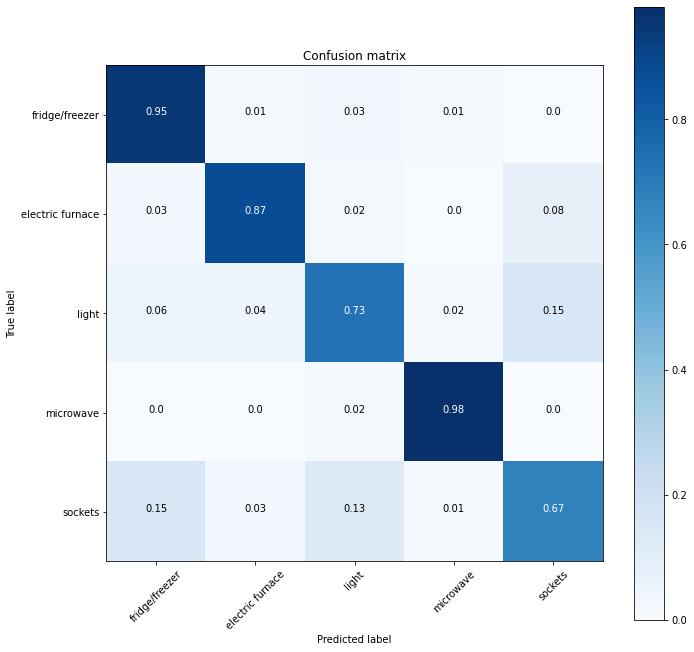

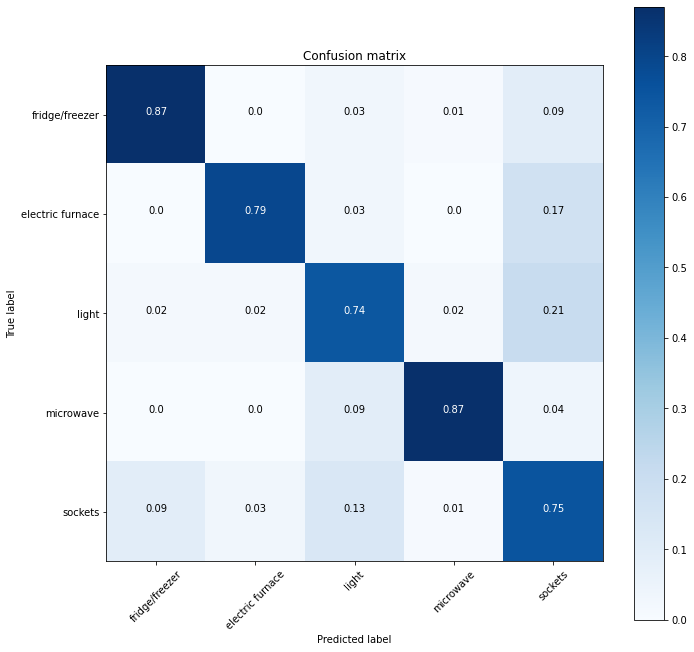

In [26]:
##TL LOOP

#datasets =["refit","ukdale","eco","redd"]
datasets = ["base"]
seeds = [42,82]
#seed =82
#F1_d = {}

for dataset in datasets:
    F1_a = []
    for seed in seeds:
        tf.keras.backend.clear_session()
        print("using backcbone from",dataset,"with seed",seed)
        x_train, x_test, y_train,y_test, d_class_weights = split_to_train_test(seed)

        #model_used = create_tl_model(dataset)
        model_used = LSTM_3D_V56(x_train,num_of_classes,lr = 0.00002) #0
        
        model_used.fit(x_train, y_train, batch_size = 64, epochs = 150, verbose = 1,class_weight=d_class_weights)

        results = model_used.evaluate(x_test, y_test, verbose = 2)
        print('Test accuracy: ', results[1])

        fscore = 0
        print_eval_results()
        F1_a.append(fscore)

        del model_used

        #save f1 arr to dict    
    #F1_d[dataset] = F1_a